# Machine Learning (Summer 2020)

## Practice Session 5

May, 26th 2020

Axel Schaffland & Ulf Krumnack

Institute of Cognitive Science,
University of Osnabrück

## Today's Session

* New Sheet 05: Dimension Reduction
* Recap: Clustering (sheet 04)
* Some more python: matplotlib

# Eigenfaces

In [ ]:
%matplotlib inline
import sys
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

def read_images_from_directory(directory, suffix, shape):
    """
    Read all images found in DIRECTORY with given file
    name SUFFIX. All images should have the same SHAPE,
    specified as (rows,columns).
    
    Args:
        directory (string): Name of input directory.
        suffix (string): File type suffix.
        shape (tuple): Shape of images to be loaded.
    
    Returns:
        images (ndarray): A numpy array of shape m*rows*columns (from shape)
        names (list): A list of corresponding image names.
    """

    # initialize the image array and name list
    #images = np.empty((0, *shape))
    images = np.empty((0, ) + shape)
    names = []

    # now loop through all image files in the directory
    for file_name in glob.glob(directory + os.sep + '*.' + suffix):
        if os.path.isfile(file_name):

            # load each image (as double)
            img = plt.imread(file_name)

            # check for correct size
            if img.shape == shape:
                images = np.append(images, img.reshape((1, ) + shape), axis=0)
                names.append(os.path.basename(file_name))
            else:
                print(
                    'warning: Image "' + file_name +
                    '" with wrong size will be ignored!',
                    file=sys.stderr)

    return images, names


# image file suffix
suffix = 'pgm'

# image size
img_shape = (192, 168)


train_imgs, train_names = read_images_from_directory('images/trainimg',
                                                     'pgm', img_shape)

plt.figure(figsize=(12, 12))
plt.gray()
for i, n in enumerate(train_names):
    plt.subplot(5, 4, i + 1)
    plt.axis('off')
    plt.imshow(train_imgs[i])
    plt.title(n[5:7])
plt.show()

In [ ]:
from sklearn.decomposition import PCA


# Transform images into one-dimensional vectors.
# This will create a two dimension matrix of shape (n,k)
# with n being the number of images and k the number of
# pixels per image.
face_vecs = train_imgs.reshape((-1, np.prod(img_shape)))


# Compute the mean face.
mean_face = face_vecs.mean(axis=0)

# now we can project our images onto these eigenvectors,
# obtaining n eigenfaces (each of dimensionality k):
centered_faces = face_vecs - mean_face



pca = PCA()
pca.fit(centered_faces.T)

eigenvecs = pca.components_
eigenvals = pca.explained_variance_

# centered_faces.shape = (20, 32256)
# eigenvecs.shape = (20, 20)
# Now we can obtain the eigenfaces by projecting back into the original space.
eigenfaces = eigenvecs.T @ centered_faces

# Normalize the eigenfaces
eigenfaces = eigenfaces/np.linalg.norm(eigenfaces, axis=1)[:,np.newaxis]

assert len(eigenfaces) == len(face_vecs)

# Plot eigenvalues and eigenvectors
plt.figure(figsize=(12,5))
plt.gray();
plt.subplot(1,3,1); plt.title("The mean face")
plt.imshow(mean_face.reshape(img_shape))
plt.subplot(1,3,2); plt.title("Spectrum of eigenvalues")
plt.bar(np.arange(len(eigenvals)), eigenvals)
plt.subplot(1,3,3); plt.title("Covariance"); plt.axis('off')
plt.imshow(eigenfaces @ eigenfaces.T)
plt.show()


# ... and display the resulting eigenfaces:
plt.figure(figsize=(12, 16))
plt.gray()
for i, eigenface in enumerate(eigenfaces):
    plt.subplot(5, 4, i + 1)
    plt.axis('off')
    plt.imshow(eigenface.reshape(img_shape))
    plt.title(f"Eigenface {i} (var={100*eigenvals[i]/eigenvals.sum():.2f}%)")
plt.show()

In [ ]:
%matplotlib notebook
import ipywidgets as widgets

num_eigenfaces = 5
eigenfaces_used = eigenfaces[:num_eigenfaces]


plt.figure(figsize=(10, 10))
axes = plt.subplot(1,1,1); plt.title('Mixed Face')

def mix_and_display(p1, p2, p3, p4, p5):
    face_descriptor = np.array([p1, p2, p3, p4, p5])
    face = mean_face + (face_descriptor @ eigenfaces_used)
    plt.imshow(face.reshape(img_shape))
    plt.show()
    
    
p1 = widgets.IntSlider(min=-5000, max=5000, step=100, value=0, continuous_update=False)
p2 = widgets.IntSlider(min=-5000, max=5000, step=100, value=0, continuous_update=False)
p3 = widgets.IntSlider(min=-5000, max=5000, step=100, value=0, continuous_update=False)
p4 = widgets.IntSlider(min=-5000, max=5000, step=100, value=0, continuous_update=False)
p5 = widgets.IntSlider(min=-5000, max=5000, step=100, value=0, continuous_update=False)
ui = widgets.HBox([p1, p2, p3, p4, p5])


out = widgets.interactive_output(mix_and_display, {'p1': p1, 'p2': p2, 'p3': p3, 'p4': p4, 'p5': p5})

display(ui, out)

mix_and_display(0,0,0,0,0)


In [ ]:
# number of eigenfaces to be used
num_eigenfaces = 5

# Remark: a value of 20 (theoretical perfect reconstruction) may suffer from numerical
# instability (the last eigenface may introduce noise).
# However, a value of 19 suffices for almost perfect reconstruction ...

# Reduce the number of eigenfaces to achieve more dimensionality reduction.
eigenfaces_used = eigenfaces[:num_eigenfaces]

# Project images into the eigenface space and store
# them in a "eigenface database":
face_db = (face_vecs - mean_face) @ eigenfaces_used.T


# ... and display the original image and the stored image
print(f"Eigenfaces used: {len(eigenfaces_used)}/{len(eigenfaces)}")
plt.figure(figsize=(12, 12))
plt.gray()
for i, face in enumerate(face_db):
    restored = (face[np.newaxis] @ eigenfaces_used) + mean_face
    plt.subplot(5, 8, 2 * i + 1)
    plt.axis('off')
    plt.imshow(train_imgs[i])
    plt.title('original')
    plt.subplot(5, 8, 2 * i + 2)
    plt.axis('off')
    plt.imshow(restored.reshape(img_shape))
    plt.title('restored')
plt.show()


In [ ]:
from scipy.spatial.distance import cdist

def recognize_face(face, eigenfaces, mean_face, face_db):
    """
    Recognize a face from a face database.
    and return the index of the best matching database entry.

    The FACE is first centered and projected into the eigeface
    space provided by EIGENFACES. Then the best match is found
    according to the euclidean distance in the eigenface space.
    """
    index = -1

    # center the face
    centered = face - mean_face

    # and project it into the eigenface space
    projected = eigenfaces @ centered

    # Now compute the similarity to all known faces
    # (comparison is performed in the eigenface space)
    distances = cdist(face_db, projected[None, :])
    index = distances.argmin()

    return index


# ... and now check your function on the training set ...
def show_recognition_results(imgs, labels, train_imgs, train_labels,
                             num_eigenfaces, eigenfaces, mean_face, face_db):
    img_shape = imgs[0].shape
    plt.figure(figsize=(12, 12))
    plt.suptitle(
        'Face recognition based on {} principal components'.format(num_eigenfaces))
    plt.gray()
    for j, img in enumerate(imgs):

        # find the best match in the eigenface database
        winner = recognize_face(
            img.reshape(np.prod(img_shape)), eigenfaces, mean_face, face_db)
        name_label = labels[j][5:7]
        name_winner = train_labels[winner][5:7]

        plt.subplot(5, 8, 2 * j + 1)
        plt.axis('off')
        plt.imshow(img)
        plt.title(labels[j][5:7])

        plt.subplot(5, 8, 2 * j + 2)
        plt.axis('off')
        plt.imshow(train_imgs[winner])
        plt.title(('*' if name_label != name_winner else '') + name_winner)
    plt.show()
    
show_recognition_results(train_imgs, train_names,
                         train_imgs, train_names,
                         num_eigenfaces, eigenfaces_used, 
                         mean_face, face_db)

In [ ]:
test_imgs, test_names = read_images_from_directory('images/testimg', suffix, img_shape)


show_recognition_results(test_imgs, test_names,
                         train_imgs, train_names,
                         num_eigenfaces, eigenfaces_used, 
                         mean_face, face_db)

# Cluster metrics

## Mean and centroid distance

**Describe how the cluster metrics *mean distance* and *centroid distance* work.**

$D_{\text{mean}}$ first determines the distances of all pairs of points $(x,y)$ from $X\times Y$ and then takes the average:

$$D_{\text{mean}}(X,Y) = \frac{1}{|X|\cdot|Y|}\sum_{\vec{x}\in X,\vec{y}\in Y} d(\vec{x},\vec{y})$$ 

The $D_{\text{centroid}}$ first computes the center of each cluster and then computes the distance of these centers.  

$$D_{\text{centroid}}= d\left(\frac{1}{|X|}\sum_{\vec{x}\in X}\vec{x}, \frac{1}{|Y|}\sum_{\vec{y}\in Y}\vec{y} \right)$$

**What are the formal requirements?**

* $D_{\text{centroid}}$ can only be applied to clusters for which we can compute a center
    - (e.g. clusters of vectors in a euclidean space),

* $D_{\text{mean}}$ only requires a distance measure for cluster points
    - can be used for arbitrary general metric spaces (where it is possible to measure the distance of datapoints, but not necessarily to obtain a cluster center).

**What is the computational complexity of these distances?**

Background: [Big $\mathcal{O}$ notation](https://en.wikipedia.org/wiki/Big_O_notation) 
* sometimes also *Bachmann–Landau notation* or *asymptotic notation*
* often used to describe runtime or space requirements of algorithms
* characterization based on growth rates: how does be behaviour change with growing input
* just mentions the most significant term, ignoring constant factors, e.g. $\mathcal{O}(n^2)$, not
$\mathcal{O}(7n^2+3n)$
* usually worst case scenario

$$D_{\text{mean}}(X,Y) = \frac{1}{|X|\cdot|Y|}\sum_{\vec{x}\in X,\vec{y}\in Y} d(\vec{x},\vec{y})$$ 

* compute the distances of all pairs from $(x,y)$ from $X\times Y$
* there exist $|X|\cdot|Y|$ such pairs
    - (actually you only need half of it, as the distance is symmetric, but this does not change the order of complexity).
* So $D_{\text{mean}}(X,Y)$ has complexity $\mathcal{O}(|X|\cdot|Y|)$

$$D_{\text{centroid}}= d\left(\frac{1}{|X|}\sum_{\vec{x}\in X}\vec{x}, \frac{1}{|Y|}\sum_{\vec{y}\in Y}\vec{y} \right)$$

* compute the mean of each cluster,
* this amounts to summing up $|X|$ vectors for cluster $X$ and $|Y|$ vectors for vector $|Y|$
* $D_{\text{centroid}}$ has complexity $O(|X|+|Y|)$

**Give a numerical example of clusters (with cluster size at least 2), where these metrics lead to (a) the same result and (b) different results.**

(a) Numerical example (in the euclidean space $\mathbb{R}^2$): Cluster $X=\{(1,1), (1,4)\}$, and cluster $Y=\{(5,1),(5,4)\}$.

The the centroid of $X$ is 
$$\bar{X}=\frac{1}{2}\sum_{x\in X}x = \frac{1}{2}\left[(1,1) + (1,4)\right] = \frac{1}{2}(2,5) = (1,2.5)$$
and the centroid of $Y$ is 
$$\bar{Y}=\frac{1}{2}\sum_{y\in Y}y= \frac{1}{2}\left[(5,1) + (5,4)\right] = \frac{1}{2}(10,5) = (5,2.5)$$ 

Hence 
\begin{align*}
D_{\text{centroid}}(X,Y) &= d_2((1,2.5),(5,2.5)) \\
&=\|(5,2.5)-(1,2.5)\|_2 = \|(4, 0)\|_2 = 4
\end{align*}
and the mean distance is 
\begin{align*}
D_{\text{mean}}(X,Y) &=
\frac{1}{2\cdot 2}[d_2((1,1),(5,1)) + d_2((1,1),(5,4)) \\
& \qquad\qquad + d_2((1,4),(5,4)) + d_2((1,4),(5,4))]\\
& =\frac{1}{4}\left[4 + 5 + 5 + 4\right] = 4.5
\end{align*}

So here $D_{\text{centroid}}(X,Y) \neq D_{\text{mean}}(X,Y)$.

(b) Take the same clusters ($X=\{(1,1), (1,4)\}$ and $Y=\{(5,1),(5,4)\}$)
but now use the maximum norm instead of the Euclidean norm. 
* The centroids stay the same (they are independent of the underlying norm) and the centroid distance is

\begin{align*}
D_{\text{centroid}}(X,Y) & = d_{\infty}((5,2.5), (1,2.5))\\
& = \max\{|5-1|, |2.5-2.5|\} = \max\{4,0\} = 4
\end{align*}

* The mean distance now evaluates to 
\begin{align*}
D_{\text{mean}}(X,Y) &= \frac{1}{2\cdot 2}[d_{\infty}((1,1),(5,1)) + d_{\infty}((1,1),(5,4))\\
&\qquad\qquad + d_{\infty}((1,4),(5,4)) + d_{\infty}((1,4),(5,4))] \\
& =\frac{1}{4}\left[4 + 4 + 4 + 4\right] = 4
\end{align*}

* So now $D_{\text{centroid}}(X,Y) = D_{\text{mean}}(X,Y)$.

# Hierarchical Clustering

 Consider the following matrix of distances
 
|       |  a  |  b  |  c  |  d  |  e  |
|-------|-----|-----|-----|-----|-----|
| **a** |  0  |  2  |  6  |  10 |  9  |
| **b** |  2  |  0  |  5  |  9  |  8  |
| **c** |  6  |  5  |  0  |  4  |  5  |
| **d** |  10 |  9  |  4  |  0  |  3  |
| **e** |  9  |  8  |  5  |  3  |  0  |
 

## Perform agglomerative clustering

Do *agglomerative* average linkage clustering by hand (i.e. employing the *mean* cluster distance). Analyze how many alternatives you have to consider at each step.

* Wikipedia: [Single-linkage clustering](https://en.wikipedia.org/wiki/Single-linkage_clustering#Naive_algorithm)

* Given a set $C$ with cardinality $|C|=n$ we start with $n$ singleton sets,
* Our initiaial clusters, and then have $\tfrac12 n(n-1)$ options to join two of theses cluster to form a new one
    - in our example we could pair $a$ with any of the 4 other elements $b,c,d,e$, or $b$ with ony of the elements $c,d,e$, or $c$ with either $d$ or $e$, or $d$ with $e$, that is $\tfrac12\cdot5\cdot(5-1)=10$ possible pairs.
* We have to repeat this $n-1$ times
* So overal complexity is $\mathcal{O}(n^3)$

Step 1: find the two clusters with smallest inter-cluster distance
* In our case: the clusters $\{a\}$ and $\{b\}$ with $d_{mean}(\{a\},\{b\})=2$
* Form new cluster $\{a,b\}$

To proceed further, we have to update our distance matrix to contain the new cluster:
 
|             |  {a,b}     |  {c}      |  {d}      |  {e}     |
|-------------|------------|-----------|-----------|----------|
| **{a,b}**   |  $0.0$     |  $5.5$    |  $9.5$    |  $8.5$   |
| **c**       |  $5.5$     |  $0.0$    |  $4.0$    |  $5.0$   |
| **d**       |  $9.5$     |  $4.0$    |  $0.0$    |  $3.0$   |
| **e**       |  $8.5$     |  $5.0$    |  $3.0$    |  $0.0$   |

Now use this matrix to continue the process: the smallest distance is between $\{d\}$ and $\{e\}$, so these to clusters are merged to a new cluster $\{d,e\}$ and the cluster distance matrix has to be updated accordingly:

|               |  $\{a,b\}$ |  $\{c\}$  |  $\{d,e\}$  |
|---------------|------------|-----------|-------------|
| **{a,b}**     |  $0.0$     |  $5.5$    |  $9.0$      |
| **{c}**       |  $5.5$     |  $0.0$    |  $4.5$      |
| **{d,e}**     |  $9.0$     |  $4.5$    |  $0.0$      |

Now the smallest distance is between clusters $\{c\}$ and $\{d,e\}$, and joining these cluster and updating the distance matrix yields:

|             |  $\{a,b\}$   |  $\{c,d,e\}$  |
|-------------|--------------|---------------|
| **{a,b}**   |  $0.0$       |  $7.83$       |
| **{c,d,e}** |  $7.83$      |  $0.0$        |

So in total wie get the following dendrogram


                        {a,b,c,d,e}
                            | 7.83
               +------------+-------------+
               |                          |
               |                       {c,d,e}
               |                          | 4.5
               |                 +--------+---------+
               |                 |                  |
               |                 |                {d,e}
               |                 |                  | 3.0
             {a,b}               |             +----+----+
               | 2.0             |             |         |
        +------+------+          |             |         |
        |             |          |             |         |
       {a}           {b}        {c}           {d}       {e}
       
       

In [28]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
# a 1d condensed distance matrix
distances = np.asarray(
[ 2, 6,10, 9,
     5, 9, 8,
        4, 5,
           3])

# method = 'single', 'complete', 'average', 'centroid', 'ward'
def cluster(distances, method='average'):
    Z = linkage(distances, method=method)
    fig = plt.figure()
    dn = dendrogram(Z, labels="abcde")
    plt.show()

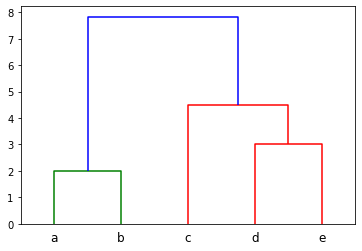

In [27]:
cluster(distances)

### b) Perform divisive clustering

Now try to do divisive average linkage clustering. Again, analyze how many splits are possible in the first step? Think of a strategy that allows to reduce this number and use this in your computation.

* For a set $C$ of cardinality $|C|=n$, there are in total $2^{n-1}-1$ possibilities to split it into two non-empty sets $A$ and $B$:
    - each element of $C$ can either be assigned to $A$ or to $B$ giving $2^n$ possible ways of assigning           elements of $C$ to $A$ and $B$.
    - This number includes symmetric cases (e.g. "AABAB" is equivalent to "BBABA") and the empty set
      (that is "AAAAA")
    - removing these leads to $\frac{2^n}{2}-1$ possible splits.  
    - in our case we would have to analyze $2^{5-1}-1=15$ splits.
* complexity is $\mathcal{O}(2^n)$
* grows exponentially with the cardinality $n$ of $C$,
* considering all possible splits is not an options even for medium-sized sets $C$.
* hence one has to apply some heuristics to find a good solution.

* One such heuristic is called DIANA (from DIvisive ANAlysis)
* works as follows: 
    - First single out the single element to form a cluster of its own, such that the cluster distance to the other elements is maximized.
    - Then elementwise grow this cluster.
    - This will give the first split into two clusters $A$ and $B$.
    - Then recursively apply this procedure to the resulting clusters.
    
* Macnaughton-Smith, P., Williams, W. T., Dale, M. B. , and Mockett, L. G. (1964), *Dissimilarity analysis: A new technique of hierarchical sub-division*, Nature, 202, 1034-1035.

Our example, first we find one element $\{a,b,c,d,e\}$ such that the cluster distance (according to the $d_{mean}$ metric) to the remaining elements is maximized:
 
|  $S_1$  |  $C_1$        |  $d_{mean}(S_1,C_1)$                   |
|---------|---------------|----------------------------------------|
| $\{a\}$ | $\{b,c,d,e\}$ |  $(2  + 6 + 10 + 9)/4 = \mathbf{6.75}$ |
| $\{b\}$ | $\{a,c,d,e\}$ |  $(2  + 5 +  9 + 8)/4 = 6.00$          |
| $\{c\}$ | $\{a,b,d,e\}$ |  $(6  + 5 +  4 + 5)/4 = 5.00$          |
| $\{d\}$ | $\{a,b,c,e\}$ |  $(10 + 9 +  4 + 3)/4 = 6.50$          |
| $\{e\}$ | $\{a,b,c,e\}$ |  $(9  + 8 +  5 + 3)/4 = 6.24$          |

So the singleton $S_1=\{a\}$ has the largest distance to the other elements. 

Now repeat this, finding the next single element from $C_1$ that maximizes the distance to the remaining elements:

|  $S_2$  |  $C_2$      | $d_{mean}(S_2,C_2)$      | $d_{mean}(S_2,S_1)$ | $d_{mean}(S_2,C_2)-d_{mean}(S_2,S_1)$ | 
|---------|-------------|--------------------------|---------------------|-----------------------------|
| $\{b\}$ | $\{c,d,e\}$ | $(5+9+8)/3 \approx 7.33$ | $2.00$              | $\mathbf{5.33}$             |
| $\{c\}$ | $\{b,d,e\}$ | $(5+4+5)/3 \approx 4.67$ | $6.00$              | $-1.33$                     |
| $\{d\}$ | $\{b,c,e\}$ | $(9+4+3)/3 \approx 5.33$ | $10.00$             | $-4.67$                     |
| $\{e\}$ | $\{b,c,e\}$ | $(8+5+3)/3 \approx 5.33$ | $9.00$              | $-3.67$                     |

So element $b$ should be clustered together with element $a$. 

Now repeat this procedure for the remaining three element $\{c,d,e\}$:

|  $S_3$  |  $C_3$    | $d_{mean}(S_3,C_3)$ | $d_{mean}(S_3,S_2)$ | $d_{mean}(S_3,C_3)-d_{mean}(S_3,S_2)$ | 
|---------|-----------|---------------------|---------------------|---------------------------------------|
| $\{c\}$ | $\{d,e\}$ | $(4+5)/2 = 4.50$    | $(6+5)/2=5.50$      | $-1.00$                               |
| $\{d\}$ | $\{c,e\}$ | $(4+3)/2 = 3.50$    | $(10+9)/2=9.50$     | $-6.00$                               |
| $\{e\}$ | $\{c,e\}$ | $(5+3)/2 = 4.00$    | $(9+8)/2=8.50$      | $-4.5$                                |

Now all differences are negative, meaning that moving a further element from $\{c,d,e\}$ to $\{a,b\}$ will not give an improvement.

Hence in the first split we split the set $C=\{a,b,c,d,e\}$ into the two clusters
$A=\{a,b\}$ and $B=\{c,d,e\}$.

Now recursively apply this procedure to $A$ and $B$: start with the cluster with the largest diameter (highest maximal distance between its objects). 
- the diameter of $A$ is $2$ and for $B$ it is $5$. 
- applying the procedure to $B$ will result in the clusters $\{c\}$ and $\{d,e\}$,
- the diameter of $\{d,e\}$ being $3$. 
- hence one first splits the set into $\{d\}$ and $\{e\}$ and then $A$ into $\{a\}$ and $\{b\}$.

This gives the final dendrogram.

## Linkage criteria

Single- and complete-linkage clustering.

In [128]:
from scipy.spatial.distance import cdist

def linkage(data, k=5, complete=False):
    """
    Runs single or complete linkage clustering.
    
    Args:
        data (ndarray): Data points to be clustered in an array with shape (num_points, 2).
        k (int): Number of clusters.
        complete (bool): Whether to run complete linkage clustering.
        
    Returns:
        ndarray: The cluster labels for each data point. Shape is (num_points).
    """
    # Initially all points are their own cluster.
    labels = np.arange(len(data))

    # Calculate distance between all points.
    # Also removing half of the matrix because 
    # its symmetrical along the diagonal.
    dst = np.tril(cdist(data, data))

    while len(set(labels)) > k:
        # Get the lowest distance of two points which
        # do not have the same label.
        r, c = np.where(dst == np.min(dst[dst > 0]))
        
        # Ignore the case when there are multiple with
        # equally smallest distance.
        r = r[0]
        c = c[0]

        # The two points are now in the same cluster,
        # so they have a distance of 0 now.
        dst[r, c] = 0

        # Make the two clusters have the same label.
        labels[labels == labels[r]] = labels[c]

        # Check if we want to do complete linkage clustering.
        if complete:
            # Update the distances of the points which are not in the same cluster.
            for i in np.nonzero(dst[r, :] > 0)[0]:
                dst[r, i] = np.max(cdist(data[i, None], data[labels == labels[r], :]))

            # The distances to c are now the same as to r, so we can just
            # set them to zero - would be duplicates otherwise.
            dst[:, c] = 0

    return labels

In [129]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Read the data.
data = np.loadtxt('points.txt')

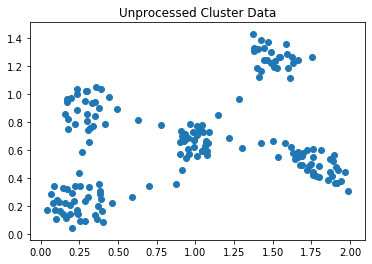

In [130]:
# Show unprocessed data set.
fig_cluster = plt.figure()
plt.scatter(data[:, 0], data[:, 1])
plt.title('Unprocessed Cluster Data')
fig_cluster.canvas.draw()

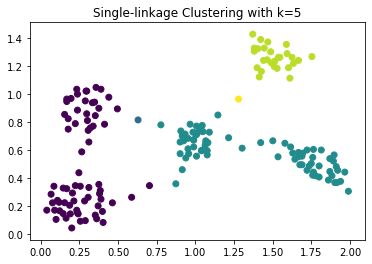

In [131]:
# Apply Single Linkage Clustering
labels = linkage(data, k=5, complete=False)
fig_single = plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.title('Single-linkage Clustering with k=5')
fig_single.canvas.draw()

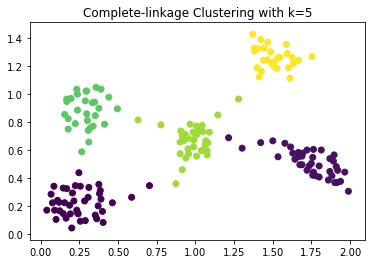

In [132]:
# Apply Complete Linkage Clustering
labels = linkage(data, k=5, complete=True)
fig_complete = plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.title('Complete-linkage Clustering with k=5')
fig_complete.canvas.draw()

What is the difference between single- and complete-linkage clustering and which is the better solution given the dataset?

* Single-linkage tends to chain clusters along the data. That is why it combines the points in the center area with those in the bottom right corner.

* Complete-linkage prefers compact clusters and thus combines each of the point heavy areas individually without merging them.

* For the dataset `points.txt`, complete-linkage is superior.

* Scikit learn: [Hierarchical Clustering - Different linkage type](https://scikit-learn.org/stable/modules/clustering.html#different-linkage-type-ward-complete-average-and-single-linkage)

# $k$-means clustering

In [57]:
from scipy.spatial.distance import cdist
from scipy.spatial import Voronoi, voronoi_plot_2d

def plot_cluster(data, centroids):
    # Calculate new labels. Labels are the index of their minimal distance to any centroid.
    labels = np.argmin(cdist(centroids, data), axis=0)
    label_count = [len(labels[labels==label]) for label in range(k)]
    
    vor = Voronoi(centroids)
    fig = voronoi_plot_2d(vor, show_vertices=False)

    plt.title(f"len(data) = {len(data)}, split = {label_count}")
    plt.scatter(data[:,0], data[:,1], c=labels)
    plt.scatter(centroids[:,0], centroids[:,1], s=100, c=range(k), edgecolor="red")
    plt.xlim(-1,40)
    plt.ylim(-1,40)
    plt.show()

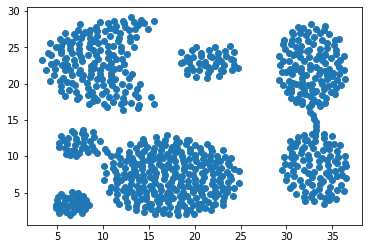

In [49]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

k = 3

data = np.loadtxt('clusterData.txt')

plt.figure('k-means with k={}'.format(k))
plt.scatter(data[:,0], data[:,1])
plt.show()

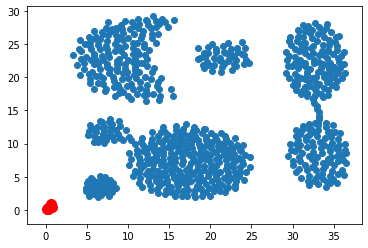

In [96]:
# Start with K reference vectors chosen randomly within a suitable bounding box
centroids = np.random.rand(k,2)
#centroids = np.random.rand(k,2) * (data.max())
#centroids = data[np.random.choice(len(data), k, replace=False)]
#centroids = np.random.permutation(data)[:k]

plt.figure('k-means with k={}'.format(k))
plt.scatter(data[:,0], data[:,1])
plt.scatter(centroids[:,0], centroids[:,1], s=100, color="red")
plt.show()

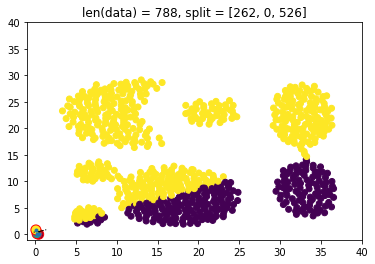

In [63]:
plot_cluster(data, centroids)

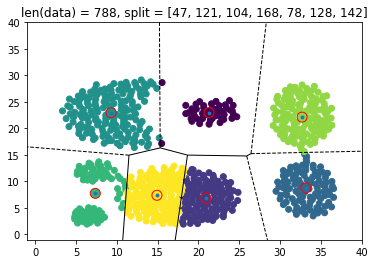

In [94]:
# Update centroids using the new cluster labels.
labels = np.argmin(cdist(centroids, data), axis=0)
for label in range(k): 
    centroids[label, :] = np.mean(data[labels == label], axis=0)
    
plot_cluster(data, centroids)

In [65]:
print(centroids)

[[23.96755725  6.50706107]
 [        nan         nan]
 [17.37480989 17.98954373]]


How could one handle situations when one or more clusters end up containing 0 elements?

[[23.96755725  6.50706107]
 [14.9        27.55      ]
 [17.37480989 17.98954373]]


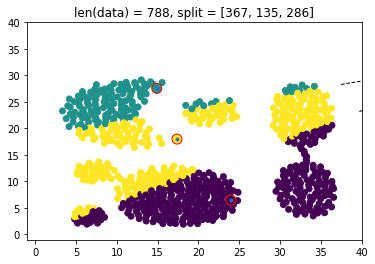

In [66]:
for label in range(k): 
    if not np.any(labels == label):
        # Cluster is empty, set its centroid to the furthest outlier.
        blacksheep = np.argmax(cdist(centroids, data).max(axis=1))
        centroids[label, :] = data[blacksheep, :]

print(centroids)
plot_cluster(data, centroids)

In [67]:
def kmeans(data, k=3):
    """
    Applies kmeans clustering to the data using k initial clusters.
    data is expected to be a numpy array of size n*2, 
    n being the amount of observations in the data. This function returns
    the centroids and the labels for the clusters data (1,1,3,5,5,5,...)
    """
    # Initial centroids are k random samples from the data.
    centroids = data[np.random.randint(0, data.shape[0], k)]
    old_centroids = np.zeros(centroids.shape)
    
    # Initial labels are all.. something.
    labels = np.ndarray(data.shape[0])
    
    # Lets keep count of our iterations to avoid infinite loops.
    iterations = 0
    
    while np.any(np.abs(centroids - old_centroids) > np.finfo(float).eps) and iterations < 1000:
        # Keep count of iterations and remember current centroids for change calculation.
        iterations += 1
        # Copy the centroids and keep them for break condition check.
        old_centroids = np.copy(centroids)
        
        # Calculate new labels. Labels are the index of their minimal distance to any centroid.
        labels = np.argmin(cdist(centroids, data), axis=0)
        
        # Update centroids using the new cluster labels.
        for label in range(k): 
            # Check for empty clusters.
            if np.any(labels == label):
                # Cluster is not empty, move its centroid to new mean.
                centroids[label, :] = np.mean(data[labels == label], axis=0)
            else:
                # Cluster is empty, set its centroid to the furthest outlier.
                blacksheep = np.argmax(cdist(centroids, data), axis=0)
                centroids[label, :] = data[blacksheep, :]

    return labels, centroids

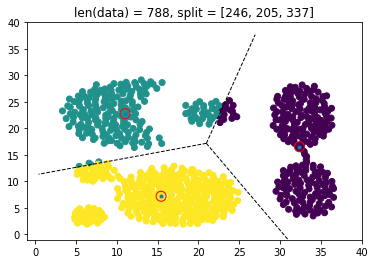

In [156]:
import matplotlib.pyplot as plt

data = np.loadtxt('clusterData.txt')

# Test different ks here
k = 3  # 3 or 7
labels, centroids = kmeans(data, k)
plot_cluster(data, centroids)

Why might the clustering for k=7 not look optimal? 

* K-Means works best for datasets in which clusters have the same circular shape and the same amount of datapoints per cluster.
* in this example inter- and intra cluster variance varies together with the number of datapoints per cluster.
* the outcome of $k$-Means
    - may be a local minimum (not the global optimum)
    - depends on the random initialization of the cluster centers

Remark: Gaussian Mixture Models may be an alternative here
* different cluster sizes, 
* different distributions per cluster

## (Pseudo) random numbers

* most libraries that offer random numbers actually compute pseudo-random numbers
    - sequences of numbers that look random, but are computed deterministically

In [168]:
import numpy as np
print(np.random.randint(0, 10, 5))

[6 5 9 4 2]


* the random number generator can be seeded (initialized with a start value)

In [165]:
np.random.seed(13)

* essential for reproducibility

# Python: Matplotlib

Matplotlib is an excellent 2D and 3D graphics library for generating scientific figures. Some of the many advantages of this library include:

* Easy to get started
* Great control of every element in a figure, including figure size and DPI. 
* Support for $\LaTeX$ formatted labels and texts
* High-quality output in many formats, including PNG, PDF, SVG, EPS, and PGF.
* GUI for interactively exploring figures *and* support for headless generation of figure files (useful for batch jobs).
* all aspects of the figure can be controlled *programmatically*

More information at the Matplotlib web page: http://matplotlib.org/

To get started using Matplotlib in a Python program, import `matplotlib` and/or `matplotlib.plt`:

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

`matplotlib.pyplot` is a simple API to Matplotlib (similar to MATLAB)
* can be used for most everyday tasks
* alternative: OOP API

## Example: plotting a function

In [ ]:
x = np.linspace(0, 7, 100)
y = np.sin(x)

plt.figure()
plt.plot(x, y)
plt.show()

One can also place multiple plots into one graph:

In [ ]:
plt.figure()
plt.plot(x, np.sin(x))
plt.plot(x, np.cos(x))
plt.show()

or more compact:

In [ ]:
plt.figure()
plt.plot(x, np.sin(x), x, np.cos(x))
plt.show()

In [ ]:
x = np.linspace(0,2*np.pi,100)
plt.figure()
plt.gca().set_aspect('equal')
plt.plot(np.cos(x), np.sin(x))
plt.show()

## Setting colors, linewidths, linetypes

Matplotlib, provides multiple was to specify color, linewidth, and linetype.

### Colors

* colors can be provided using the `color=` argument
* Matplotlib understands colors by their names or RGB hex codes
* an optional `alpha` value can be provided

In [ ]:
x = np.linspace(0, 5, 10)

plt.figure()
plt.plot(x, x+1, color="red")              # half-transparant red
plt.plot(x, x+2, color="#1155dd")          # RGB hex code for a bluish color
plt.plot(x, x+3, color="green", alpha=0.5) # half-transparant green
plt.show()

### Line width

* the line width can be changed using the `linewidth` or `lw` keyword argument

In [ ]:
plt.figure()
plt.plot(x, x, color="red")
plt.plot(x, x-1, color="red", linewidth=0.5)
plt.plot(x, x+1, color="red", lw=2)
plt.show()

### Line style

* the line style can be changed using the `linestyle` or `ls` keyword argument

In [ ]:
plt.figure()
plt.plot(x, x, color="red")
plt.plot(x, x+1, color="red", linestyle='-')
plt.plot(x, x+2, color="red", ls='-.')
plt.plot(x, x+3, color="red", ls=':')
plt.show()

### Marker

* Markers can be formated using the `marker` keyword argument
* markers can be further formated using `markersize`, `markerfacecolor`, `markeredgewidth`, and `markeredgecolor`

In [ ]:
plt.figure()
plt.plot(x, x, color="red")
plt.plot(x, x+1, color="red", marker='+')
plt.plot(x, x+2, color="red", marker='*')
plt.plot(x, x+3, color="red", marker='o')
plt.plot(x, x+4, color="red", marker='s')
plt.plot(x, x+5, color="red", marker='*',
         markersize=15, markerfacecolor="yellow",
         markeredgewidth=2, markeredgecolor="blue")
plt.show()

### Compact formating

* Plots can be formated using short format string, e.g., `'b.-'` means a blue line with dots

In [ ]:
plt.figure()
plt.plot(x, x**2, 'b.-') # blue line with dots
plt.plot(x, x**3, 'g:*') # green dotted line with stars
plt.show()

In [ ]:
n=7
x = np.linspace(0,2*np.pi,n+1)
plt.figure()
plt.gca().set_aspect('equal')
plt.plot(np.cos(x), np.sin(x), color='blue', marker='*', markeredgecolor='red')
plt.show()

## Legends, labels and titles, annotations

Usually, you should be "decorated" your figure to explain what is depicted.

### Figure titles

A title can be added to each axis instance in a figure. To set the title, use the `set_title` method in the axes instance:

In [ ]:
x = np.linspace(0,2*np.pi,70)
plt.figure()
plt.plot(x, np.sin(x), x, np.cos(x))
plt.title("Sine and cosine")
plt.show()

### Axis labels

Similarly, with the methods `set_xlabel` and `set_ylabel`, we can set the labels of the X and Y axes:

In [ ]:
x = np.linspace(0,2*np.pi,70)
plt.figure()
plt.plot(x, np.sin(x), x, np.cos(x))
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Legends

Legends can be added to curves by providing a `label` for each plot and calling the `legend` method.

In [ ]:
x = np.linspace(0,2*np.pi,70)
plt.figure()
plt.plot(x, np.sin(x), label='sine')
plt.plot(x, np.cos(x), label='cosine')
plt.legend()
plt.show()

### Text annotations

* test annotations in matplotlib figures can be added using the `text` function.
* the `text` function supports LaTeX formatting just like axis label texts and titles

In [ ]:
x = np.linspace(-0.75, 1., 100)

plt.figure()
plt.plot(x, x**2, x, x**3)
plt.text(0.15, 0.2, "$\sum$", fontsize=40, color="blue")
plt.text(0.65, 0.1, "$y=x^3$", fontsize=20, color="green");
plt.show()

## Other 2D plot styles

* in addition to the regular `plot` method, there are a number of other functions for generating different kind of plots
* see the matplotlib plot gallery for a complete list of available plot types: http://matplotlib.org/gallery.html

In [ ]:
# A scatter plot
n = 500
x = np.random.randn(n)
y = np.random.randn(n)

plt.figure()
plt.scatter(x,y)
plt.title("scatter")
plt.show()

In [ ]:
# A step function
n = np.array([0,1,2,3,4,5])
plt.figure()
plt.step(n, 10-n**2, lw=2)
plt.title("step")
plt.show()

In [ ]:
# A bar diagram
plt.figure()
plt.bar(n, n**2, align="center", width=0.5, alpha=0.5)
plt.title("bar")
plt.show()

In [ ]:
x = np.linspace(0,2*np.pi,70)
plt.figure()
plt.fill_between(x, np.sin(x), np.cos(x), color="green", alpha=0.5)
plt.title("fill_between")
plt.show()

In [ ]:
# A histogram
n = np.random.randn(100000)
fig, axes = plt.subplots()

axes.hist(n)
axes.set_title("Default histogram")
axes.set_xlim((min(n), max(n)));

Exercises:

1. Create a normally distributed 2D dataset with given mean and standard derivation.
2. Create a scatter plot to display your dataset
3. Indicate the standard deviation by adding a corresponding circle to your plot

In [ ]:
# A scatter plot
n = 500
x = np.random.randn(n)
y = np.random.randn(n)
z = np.linspace(0,2*np.pi,100)

plt.figure()
plt.gca().set_aspect('equal')
plt.scatter(x,y)
plt.title("scatter")
plt.plot(np.cos(z), np.sin(z), color="red")
plt.plot(3*np.cos(z), 3*np.sin(z), color="orange")
plt.show()

## Summary

* MatPlotLib provides plotting functionality
* Today we saw some basic concepts that should allow you to do most of the exercises
* We may introduce some additional functionality in future sessions
* For the curious one: visit [https://matplotlib.org/]